# 深度学习与人工智能期末报告 -  林芯羽 1901211508

## 1. 背景介绍


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;近几年，人工智能的身影随处可见，从金融、医疗、家居到物联网，再到交通、传统制造业等等，为我们带来更多元化的应用场景。目前，人工智能赋能的概念亦拓展到农业之中，比如腾讯的“AI生态鹅场”及阿里、京东、网易的“AI养猪”等创新养殖技术的出现备受业内业外人士的关注。除了动物养殖，人工智能在粮食及蔬菜种植领域也被充分利用，例如微软与国际热带半干旱农作物研究所便曾利用人工智能播种应用程式及微軟Azure AI技術，结合过往气候信息预测出最佳的农耕方法及条件，以手机作为即时信息传递的媒介，帮助印度花生农提高30%的产量。通过AI技术进行高自动化及标准化的辅助，不仅有助传统农业提高产能，更能同时降低人力成本、提升产值，有效促进产业转型。

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;近年来台湾重要农产品之一的爱文芒果销量持续增长，不仅跃升为三大外销高经济生鲜果品之一，更将市场拓展至日本、韩国、美国等地。2019年开始截至当年6月底，外销量已达3,088公吨，较前一年同期的1650吨同比增加87%，再创外销佳绩。台湾芒果虽然相比过往提高了市场知名度及市占率，但是由于其他芒果出口国如菲律宾、泰国的削价竞争，使得台湾芒果尚需提升产业竞争力，在品种改良、采收后处理技术以及品牌营销手法上，都需要导入新科技协助推进。

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;其中，亟待改善的是采收后处理技术。爱文芒果采收后依品质筛选为 A、B、C 三等级，依序为出口用、内销用、加工用。现阶段爱文芒果是采取人工筛选的方式，由于面临到农村人口流失人力短缺的问题，且芒果保鲜期较短必须压缩筛果时间，使得爱文芒果的筛选过程容易出现误差，以外销金额估计，每年可能损失约1600万台币（约330万人民币）。

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;因此，为了优化芒果产业链，如何自动化的进行芒果品质筛检是当前首要思考的课题，除了能够解决农村人力不足的问题、加速筛果流程及提高筛选精度，也能够协助芒果智能产销简历的搭建，将所有的数据整合于云端，提供大众简单明确的芒果选购机制。因此，本报告将构建一个芒果等级预测模型，以爱文芒果影像资料作为输入变量X，芒果等级作为模型输出结果Y，为自动化的芒果筛选流程提供模型基础，并尝试发想预测模型的应用场景。

## 2. 数据来源与介绍
### 2.1 数据来源：

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;本报告数据来自人工智慧共创平台爱文芒果等级分类竞赛所提供的[爱文芒果影像资料](https://reurl.cc/oL0eQV) 。

### 2.2 问题描述：
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;本报告旨在建立一个芒果等级预测模型，模型的输入变量X为芒果影像，输出结果Y为芒果对应的等级。

In [2]:
#导入所需模块
from PIL import Image
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D
from keras import Model
from keras.regularizers import l2
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [3]:
train_df = pd.read_csv("./mango/train.csv") #读入训练集数据
valid_df = pd.read_csv("./mango/dev.csv") #读入测试集数据
print(len(train_df)) #查看训练集样本数
print(len(valid_df)) #查看测试集样本数
train_df.head() #查看数据结构，可以看到一列为影像名称，一列为影像对应的芒果等级

5600
800


,image_id,label
0,00002.jpg,C
1,00003.jpg,C
2,00004.jpg,B
3,00005.jpg,A
4,00007.jpg,A


In [4]:
np.random.seed(10) #设定随机种子
drop_indices = np.random.choice(train_df.index, 1600, replace=False) #随机抽取1600个index
#将随机选取出的1600个样本移除，使得子训练集剩下4000笔样本（使测试集样本数为全样本的20%）
train_subset = train_df.drop(drop_indices) 

In [5]:
#查看三种芒果等级在各数据集中的样本量分布
print('train data: \n', train_subset.groupby('label').size())
print('validation data: \n', valid_df.groupby('label').size())

train data: 
 label
A    1298
B    1461
C    1241
dtype: int64
validation data: 
 label
A    243
B    293
C    264
dtype: int64


### 2.3 数据介绍

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;原始竞赛提供的数据集中，训练集的样本量为5600笔，测试集为800笔，而竞赛发布的baseline是基于测试集数据进行精度评估的。由于希望维持模型精度的可比性，同时又能在模型外样本测试时使用全样本20%数据，本报告模型最终的训练集样本量为4000笔（从原竞赛训练集中随机挑选），测试集仍为800笔。数据集包含影像以及影像对应之等级标签，芒果等级标签分为三类：A等级（出口用）、B等级（内销用）、C等级（加工用），三种等级在各数据集中的样本量分布如下表，可以看到整体数据分布没有明显不均衡的情况。

|等级|训练集 |测试集 |
|---|------|------|
| A  |1298  |243   |
| B  |1461  |293   |
| C  |1241  |264   |
|总和|4000 |800 |


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;本报告的数据示例如下，输入数据X为芒果影像，输出结果Y为对应的芒果等级。可以看到，A等级的芒果看起来完全没有瑕疵，色泽均匀漂亮；B等级色泽较为不均，但是瑕疵范围可以用一个拇指盖住，仍可作为贩卖用途；C等级的芒果上头有黑班，因此不能直接贩卖，只能作为加工用途。

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;在数据集的准备上，我将输入影像的分辨率设为256*256，批量大小设为32，并对训练集图片使用数据增强方法以更好的训练模型。

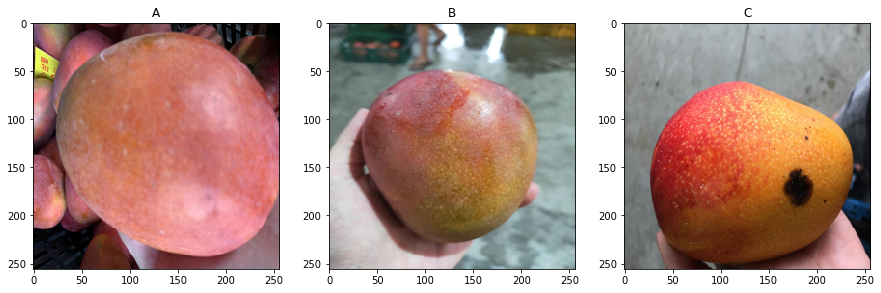

In [28]:
fig, ax = plt.subplots(1,3) #张开一个1X3的图片区域
fig.set_figheight(5) #设定图片区域的高
fig.set_figwidth(15) #设定图片区域的宽
file_path = './mango/C1-P1_Dev/' #影像文件夹路径
grade_list = ['A', 'B', 'C'] #芒果等级列表
for i in range(3):
    img = Image.open(file_path + valid_df[valid_df.label == grade_list[i]].iloc[0].image_id) #读入图片
    img = img.resize([256, 256]) #设定图片分辨率
    img = np.array(img) #将图片转为numpy数组
    ax[i].imshow(img) #显示图片
    ax[i].set_title(grade_list[i]) #标题展示图片对应的芒果等级

In [7]:
img_size = 256 #设定分辨率

#生成训练的数据生成器，采用数据增强技巧
train_generator = ImageDataGenerator(
        rescale = 1./255, #把像素值缩放到0和1之间
        shear_range = 0.2,  #进行剪切变换
        zoom_range = 0.3, #放大图片
        rotation_range = 20, #设定旋转角度范围
        width_shift_range = 0.1, #设定水平位移范围
        height_shift_range = 0.1, #设定垂直位移范围
        channel_shift_range = 0.05, #设定随机通道偏移的幅度
        fill_mode = 'nearest', #填充进行变换时缺失的点
        horizontal_flip = True #允许水平反转
        ).flow_from_dataframe(
        dataframe = train_subset, #设定dataframe
        directory = 'mango/C1-P1_Train', #设定文件夹路径
        x_col = 'image_id', y_col = 'label', #设定影像名称跟标签所在的列名
        target_size = (img_size, img_size), #设定图片尺寸
        batch_size = 64, shuffle = True, #设定batch size并将shuffle设为True，在每个epoch前随机打乱输入样本的顺序
        class_mode='categorical') #将标签数组以one-hot形式呈现

#生成测试的数据生成器
validation_generator = ImageDataGenerator(
        rescale = 1./255).flow_from_dataframe(
        dataframe=valid_df,
        directory='mango/C1-P1_Dev',
        x_col= 'image_id', y_col='label',
        target_size=(img_size, img_size),
        batch_size=32, class_mode='categorical')

Found 4000 validated image filenames belonging to 3 classes.
Found 800 validated image filenames belonging to 3 classes.


##  3. 建立模型
### 3.1 模型设计思想

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;模型架构方面，由于数据集本身规模较小，参数个数不宜过多。因此最终模型以四层卷积层、四层池化层以及两层全连接层作为整体架构，卷积核数目由少到多，使得特征提取越来越细致，从而进行图片识别。同时，在此基础上使用批标准化、Dropout、正则化等技巧避免数据不稳定及模型过拟合的情况。

In [25]:
input_layer = Input([img_size, img_size, 3]) #设定输入数据的形状：256*256*3，此层输出为样本数*256*256*3
x = input_layer
x = BatchNormalization()(x) #将输入数据进行标准化处理
#same卷积，输出形状为样本数*256*256*32(卷积核个数),激活函数采用relu，使用kernel_regularizer參數添加l2正則化
x = Conv2D(32, [3, 3], padding = 'same', activation = 'relu', kernel_regularizer = l2(0.001))(x) 
x = BatchNormalization()(x) #将输入数据进行标准化处理
x = MaxPooling2D([2, 2])(x) #valid池化，输出形状为样本数*128（256/2 = 128）*128*32
x = Dropout(0.2)(x) #将输入数据按比率（0.2）随机设置为 0
#same卷积，输出形状为样本数*128*128*64(卷积核个数),激活函数采用relu，使用kernel_regularizer參數添加l2正則化
x = Conv2D(64, [3, 3], padding = 'same', activation = 'relu', kernel_regularizer = l2(0.001))(x) 
x = BatchNormalization()(x) #将输入数据进行标准化处理
x = MaxPooling2D([2, 2])(x) #valid池化，输出形状为样本数*64（128/2 = 64）*64*64
x = Dropout(0.3)(x) #将输入数据按比率（0.3）随机设置为 0
#valid卷积，输出形状为样本数*62(64-3+1=62)*62*128(卷积核个数),激活函数采用relu，使用kernel_regularizer參數添加l2正則化
x = Conv2D(128, [3, 3], activation = 'relu', kernel_regularizer = l2(0.001))(x)
#valid卷积，输出形状为样本数*60(62-3+1=60)*60*128(卷积核个数),激活函数采用relu，使用kernel_regularizer參數添加l2正則化
x = Conv2D(128, [3, 3], activation = 'relu', kernel_regularizer = l2(0.001))(x)
x = BatchNormalization()(x) #将输入数据进行标准化处理
x = MaxPooling2D([2, 2])(x) #valid池化，输出形状为样本数*30（60/2 = 30）*30*128
x = GlobalAveragePooling2D()(x) #对于输入数据做全局平均池化，输出数据的形状为样本数*128
x = Dense(256, activation = 'relu')(x) #通过全连阶层将输入数据连接到256个节点，输出形状为样本数*256
x = Dropout(0.4)(x) #将输入数据按比率（0.4）随机设置为 0
#通过全连阶层将输入数据连接到3个节点，使用softmax函数输出三分类概率分布，输出数据的形状为样本数*3
x = Dense(3, activation = 'softmax')(x) 
output_layer = x
model = Model(input_layer, output_layer) #设定好Model的input/output layer即可建立模型
model.summary() #展示模型的内部结构

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 256, 256, 3)       12        
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_70 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 128, 128, 64)      184

### 3.2 模型参数解读

Input、MaxPooling2D、GlobalAveragePooling2D和Dropout层不消耗参数，参数个数皆为0。<br>
Con2D层的参数个数 =（卷积核长 * 卷积核宽 * 通道数 + 1）* 卷积核个数，加1为截距项。<br>
BatchNormalization层的参数个数 = 通道数 * 4（数据均值、方差、线性偏移参数γ和β），其中均值、方差是可以被估计的，为不需训练的参数。<br>
Dense层的参数个数 = （输入数据维度 + 1）* 输出数据维度，加1为截距项。

各层的参数个数计算如下：<br>
第一层BatchNormalization的参数个数 = 3 * 4 = 12（其中不需训练之参数有6个）<br>
第一层Con2D的参数个数 = （3 * 3 * 3 + 1）* 32 = 896 <br>
第二层BatchNormalization的参数个数 = 32 * 4 = 128（其中不需训练之参数有64个）<br>
第二层Con2D的参数个数 = （3 * 3 * 32 + 1）* 64 = 18496 <br>
第三层BatchNormalization的参数个数 = 64 * 4 = 256（其中不需训练之参数有128个）<br>
第三层Con2D的参数个数 = （3 * 3 * 64 + 1）* 128 = 73856 <br>
第四层Con2D的参数个数 = （3 * 3 * 128 + 1）* 128 = 147584 <br>
第四层BatchNormalization的参数个数 = 128 * 4 = 512（其中不需训练之参数有256个）<br>
第一层Dense的参数个数 = （128 + 1）* 256 = 33024 <br>
最后一层Dense的参数个数 = (256 + 1) * 3 = 771 <br>
整个模型的总参数个数 = 12 + 896 + 128 + 18496 + 256 + 73856 + 147584 + 512 + 33024 + 771 = 275535 <br>
其中不需训练的参数个数 = 6 + 64 + 128 + 256 = 454 <br>
需训练的参数个数 = 275535 - 454 = 275081 <br>

### 3.3 模型训练

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;模型训练方面，模型的损失函数为categorical_crossentropy，评价函数为准确率。另外，使用RMSProp优化器，学习率设为0.001，衰减率设为0.0001，使得学习率能够逐步递减，减缓训练后期loss的下降困难。循环次数Epochs设为250，并在训练过程中存取validation准确率最佳的模型作为最终模型。

In [26]:
#设定模型损失函数、优化器（学习率、衰减率）、评价函数
model.compile(loss='categorical_crossentropy', optimizer = RMSprop(lr = 0.001, decay = 1e-4), metrics=['accuracy'])

In [27]:
filepath= './model/model-{epoch:02d}-{val_accuracy:.2f}.hdf5' #设定model存取的路径，档名包含当前epoch和val_accuracy
#设定model存取的checkpoint，仅存取比当前最佳模型的val_accuracy还高的模型
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose = 1, save_best_only = True, mode = 'max') 
callbacks_list = [checkpoint]

In [28]:
#进行模型拟合，epochs（循环次数）设为250，并设定callbacks来存取表现较佳的模型
history = model.fit_generator(train_generator,
                              epochs=250,
                              validation_data=validation_generator, 
                              callbacks = callbacks_list)

Epoch 1/250
125/125 [==============================] - 116s 927ms/step - loss: 1.1737 - accuracy: 0.5512 - val_loss: 1.3352 - val_accuracy: 0.3663

Epoch 00001: val_accuracy improved from -inf to 0.36625, saving model to ./model/model-01-0.37.hdf5
Epoch 2/250
125/125 [==============================] - 108s 867ms/step - loss: 1.0318 - accuracy: 0.5865 - val_loss: 1.0819 - val_accuracy: 0.3825

Epoch 00002: val_accuracy improved from 0.36625 to 0.38250, saving model to ./model/model-02-0.38.hdf5
Epoch 3/250
125/125 [==============================] - 109s 872ms/step - loss: 0.9868 - accuracy: 0.5817 - val_loss: 1.1383 - val_accuracy: 0.4837

Epoch 00003: val_accuracy improved from 0.38250 to 0.48375, saving model to ./model/model-03-0.48.hdf5
Epoch 4/250
125/125 [==============================] - 108s 866ms/step - loss: 0.9436 - accuracy: 0.5968 - val_loss: 0.8825 - val_accuracy: 0.5487

Epoch 00004: val_accuracy improved from 0.48375 to 0.54875, saving model to ./model/model-04-0.55.hdf5


Epoch 00077: val_accuracy did not improve from 0.80500
Epoch 78/250
125/125 [==============================] - 108s 861ms/step - loss: 0.5180 - accuracy: 0.7945 - val_loss: 0.4985 - val_accuracy: 0.7987

Epoch 00078: val_accuracy did not improve from 0.80500
Epoch 79/250
125/125 [==============================] - 108s 862ms/step - loss: 0.5170 - accuracy: 0.7958 - val_loss: 0.2833 - val_accuracy: 0.7812

Epoch 00079: val_accuracy did not improve from 0.80500
Epoch 80/250
125/125 [==============================] - 108s 862ms/step - loss: 0.5184 - accuracy: 0.7925 - val_loss: 0.5473 - val_accuracy: 0.7950

Epoch 00080: val_accuracy did not improve from 0.80500
Epoch 81/250
125/125 [==============================] - 107s 859ms/step - loss: 0.5040 - accuracy: 0.7977 - val_loss: 0.7120 - val_accuracy: 0.7750

Epoch 00081: val_accuracy did not improve from 0.80500
Epoch 82/250
125/125 [==============================] - 108s 862ms/step - loss: 0.5272 - accuracy: 0.7937 - val_loss: 0.4809 - v


Epoch 00117: val_accuracy did not improve from 0.81500
Epoch 118/250
125/125 [==============================] - 108s 866ms/step - loss: 0.4623 - accuracy: 0.8282 - val_loss: 0.5112 - val_accuracy: 0.7962

Epoch 00118: val_accuracy did not improve from 0.81500
Epoch 119/250
125/125 [==============================] - 108s 865ms/step - loss: 0.4727 - accuracy: 0.8220 - val_loss: 0.8976 - val_accuracy: 0.7700

Epoch 00119: val_accuracy did not improve from 0.81500
Epoch 120/250
125/125 [==============================] - 108s 864ms/step - loss: 0.4708 - accuracy: 0.8177 - val_loss: 1.1467 - val_accuracy: 0.7850

Epoch 00120: val_accuracy did not improve from 0.81500
Epoch 121/250
125/125 [==============================] - 108s 867ms/step - loss: 0.4840 - accuracy: 0.8125 - val_loss: 0.7441 - val_accuracy: 0.7538

Epoch 00121: val_accuracy did not improve from 0.81500
Epoch 122/250
125/125 [==============================] - 108s 862ms/step - loss: 0.4737 - accuracy: 0.8148 - val_loss: 0.564

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



125/125 [==============================] - 108s 864ms/step - loss: 0.4308 - accuracy: 0.8447 - val_loss: 0.6871 - val_accuracy: 0.7925

Epoch 00172: val_accuracy did not improve from 0.81500
Epoch 173/250
125/125 [==============================] - 108s 861ms/step - loss: 0.4354 - accuracy: 0.8300 - val_loss: 0.5315 - val_accuracy: 0.7538

Epoch 00173: val_accuracy did not improve from 0.81500
Epoch 174/250
125/125 [==============================] - 108s 864ms/step - loss: 0.4223 - accuracy: 0.8428 - val_loss: 0.3470 - val_accuracy: 0.8087

Epoch 00174: val_accuracy did not improve from 0.81500
Epoch 175/250
125/125 [==============================] - 108s 861ms/step - loss: 0.4398 - accuracy: 0.8325 - val_loss: 0.7230 - val_accuracy: 0.7887

Epoch 00175: val_accuracy did not improve from 0.81500
Epoch 176/250
125/125 [==============================] - 108s 865ms/step - loss: 0.4223 - accuracy: 0.8475 - val_loss: 0.5700 - val_accuracy: 0.7987

Epoch 00176: val_accuracy did not improve fr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



125/125 [==============================] - 108s 863ms/step - loss: 0.3887 - accuracy: 0.8677 - val_loss: 0.5379 - val_accuracy: 0.7675

Epoch 00241: val_accuracy did not improve from 0.81500
Epoch 242/250
125/125 [==============================] - 108s 866ms/step - loss: 0.3864 - accuracy: 0.8687 - val_loss: 1.4359 - val_accuracy: 0.7788

Epoch 00242: val_accuracy did not improve from 0.81500
Epoch 243/250
125/125 [==============================] - 108s 864ms/step - loss: 0.3767 - accuracy: 0.8708 - val_loss: 0.6730 - val_accuracy: 0.7788

Epoch 00243: val_accuracy did not improve from 0.81500
Epoch 244/250
125/125 [==============================] - 108s 863ms/step - loss: 0.3784 - accuracy: 0.8637 - val_loss: 0.7482 - val_accuracy: 0.7862

Epoch 00244: val_accuracy did not improve from 0.81500
Epoch 245/250
125/125 [==============================] - 108s 867ms/step - loss: 0.3852 - accuracy: 0.8677 - val_loss: 0.7768 - val_accuracy: 0.7700

Epoch 00245: val_accuracy did not improve fr

## 4. 模型检验

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;下图为模型在训练过程中对训练集及测试集的预测准确率，可以看到模型在大约100个epochs之后出现了过拟合的清形，外样本的预测准确率在那之后没有明显上升。从下方结果可以显示，训练过程中所存取的最佳模型在测试集的准确率为81.50%，而竞赛主办方提供了融合ResNeXt、AlexNet、VGG16及DenseNet的baseline model在测试集上的准确率为71.625%。总的来说，本报告的最终模型在测试集的表现相较baseline高了将近10%。

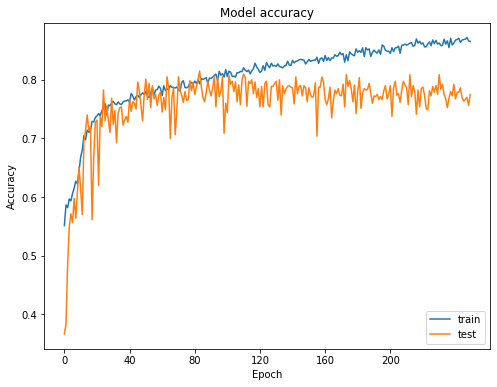

In [37]:
plt.figure(figsize = (8, 6)) #展开图片区域
plt.plot(history.history['accuracy']) #将训练时的accuracy画出
plt.plot(history.history['val_accuracy']) #将测试时的accuracy画出
plt.title('Model accuracy') #设置标题
plt.ylabel('Accuracy') #设置y坐标名
plt.xlabel('Epoch') #设置x坐标名
plt.xticks(np.arange(0,201,40)) #调整x坐标轴刻度
plt.legend(['train', 'test'], loc = 'lower right') #设置图例
plt.show() #展示图片

In [39]:
best_model = load_model('./model/model-84-0.81.hdf5') #导入先前存取的最佳模型
scores = best_model.evaluate_generator(validation_generator) #使用测试集评估模型预测精度
print('外样本准确率为:{:.2%}'.format(scores[1])) #印出模型最终的外样本预测精度

外样本准确率为:81.50%


## 5. 产品设计

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;本预测模型基于实际数据，能够应用于自动化的芒果品质筛检，协助果农在人力短缺及保鲜期时限压力的情况下快速评定芒果等级，作为后续商品分销的评判基准。基于此理念，本报告尝试将本模型产品化，发展成一个全方位的芒果筛选智能系统，为生产者提供芒果等级预测以及芒果产销简历上传的服务。

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;首先，如图1所示，用户可以通过系统登录界面登入自己的账户或注册新账号。进入系统后便可以使用系统相机功能为待筛选的芒果拍照，如图2所示。相片拍摄完毕后，系统会将影像资料上传到云端的预测模型，接着返回芒果等级的预测结果，如图3上半部所示，可以看到芒果被评定为C等级，主要原因是该芒果上有明显黑斑，不能作为商品直接卖给消费者，因此系统建议用户将芒果分销给加工业者做成芒果制品。

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;另一方面，台湾农委会在2004年开始推动农产品产销简历制度，使得农产品从生产到流通的整个食品链过程都能公开的被追踪追溯。生产者能够更好的进行风险控管及责任归属，进一步提高品牌形象；消费者在购买时能快速的辨识产品品质，了解产地概况及生产过程；对于通路分装加工业者来说，产销简历也能强化食品安全管理，深化消费者对品牌支持度。因此，本系统亦协助用户将芒果等级及相关生产信息进行统整，如图3下半部所示，在确认过信息无误后，用户可以点击下方一键创建简历的按钮，将产销简历上传至产销简历公开信息平台，以利后续追踪使用。

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;通过使用此系统，芒果果农不仅能够将芒果采收后的品质筛选过程全面自动化升级，有效降低成本并提升产值，更能进一步与产销简历做结合，将所有数据整合于公开信息平台，提供大众简易明确的选购机制及安全的芒果生产分销过程。

![mangoAI](./芒果系统界面.png)